In [1]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem
import pandas as pd
import numpy as np
import copy

check what materials are in the model

In [2]:
samples_temp = []
orientation_values = [180,270] #,270
wwr_values = [.15, .5, .9] #
glazing_values = [0.7,0.75,0.8,0.85,0.9] #
tickness_values = np.linspace(0.001,0.35,10)
for ori in orientation_values:
    for wwr_ in wwr_values:
        for glazing in glazing_values:
            for tickness in tickness_values:
                samples_temp.append({'Orientation': ori,
                                     'Window to Wall Ratio': wwr_,
                                     'glazing STNI': glazing,
                                     'Insulation Thickness': tickness,})
samples = pd.DataFrame.from_dict(samples_temp)
samples
                

,Orientation,Window to Wall Ratio,glazing STNI,Insulation Thickness
0,180,0.15,0.7,0.001000
1,180,0.15,0.7,0.039778
2,180,0.15,0.7,0.078556
3,180,0.15,0.7,0.117333
4,180,0.15,0.7,0.156111
...,...,...,...,...
295,270,0.90,0.9,0.194889
296,270,0.90,0.9,0.233667
297,270,0.90,0.9,0.272444
298,270,0.90,0.9,0.311222


To calculate the Floor area 

In [3]:
files= ['on.idf','off.idf']
results = pd.core.frame.DataFrame()
for item in files:
    building = ef.get_building('/home/ict4bd/Desktop/Project/IDF final/'+item)
    insulation = FieldSelector(class_name='Material', object_name='_isolante_01445', field_name='Thickness')
    insulationPR = Parameter(selector=insulation, value_descriptor=RangeParameter(0.0001, 0.47),
                             name='Insulation Thickness')

    glazing = FieldSelector(class_name='WindowMaterial:Glazing', object_name='38',
                            field_name='Solar Transmittance at Normal Incidence')
    glazingPR = Parameter(selector=glazing, value_descriptor=RangeParameter(.7, .94), name='glazing STNI')

    window_to_wall = wwr(CategoryParameter(options=[.15,.5,.9]))

    orientation = FieldSelector(class_name='Building', field_name='North Axis')
    orientationPR = Parameter(selector=orientation, value_descriptor=CategoryParameter(options=[180, 270]),
                              name='Orientation')

    parameters = [orientationPR , window_to_wall, glazingPR,insulationPR]

    objectives = ['Electricity:Facility', 'DistrictHeating:Facility', 'DistrictCooling:Facility']

    problem = EPProblem(parameters, objectives)
    evaluator = EvaluatorEP(problem, building, out_dir='Simulation_Output/output_besos', error_mode='Silent', err_dir='Simulation_Output/output_besos',
                            epw='/home/ict4bd/Desktop/Project/Weather_file/ITA_Torino.160590_IWEC.epw')
    outputs = evaluator.df_apply(samples, keep_input=True)    
    if item.split('.')[0] == 'on':
        outputs['Ventilation'] = 'on'
    else:
        outputs['Ventilation'] = 'off'
    
    results = results.append(outputs)
    print(str(item) + ' is finished')

    

/home/ict4bd/py3/lib/python3.6/site-packages/besos/parameters.py:400: UserWarning: wwr is intended to be used with RangeParameter. Your value_descriptor is CategoryParameter(options=[0.15, 0.5, 0.9])
  warnings.warn(f'wwr is intended to be used with RangeParameter. Your value_descriptor is {value_descriptor}')


on.idf is finished


/home/ict4bd/py3/lib/python3.6/site-packages/besos/parameters.py:400: UserWarning: wwr is intended to be used with RangeParameter. Your value_descriptor is CategoryParameter(options=[0.15, 0.5, 0.9])
  warnings.warn(f'wwr is intended to be used with RangeParameter. Your value_descriptor is {value_descriptor}')


off.idf is finished


In [4]:
total_area= 0
for Zones in building.idfobjects["Zone"]:
    total_area += float(Zones.checkrange("Floor_Area")) 
total_area

133.3323

In [5]:
results['Electricity:Facility'] /= 3.6e6
results['DistrictHeating:Facility'] /= 3.6e6
results['DistrictCooling:Facility'] /= 3.6e6
results['TotalConsumption'] = results['DistrictHeating:Facility'] + results['DistrictCooling:Facility']
results

,Orientation,Window to Wall Ratio,glazing STNI,Insulation Thickness,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Ventilation,TotalConsumption
0,180,0.15,0.7,0.001000,16991.626847,10369.496725,9931.316403,on,20300.813128
1,180,0.15,0.7,0.039778,16991.626847,5206.949406,7344.942652,on,12551.892058
2,180,0.15,0.7,0.078556,16991.626847,3873.742188,6952.574097,on,10826.316285
3,180,0.15,0.7,0.117333,16991.626847,3270.901004,6786.132577,on,10057.033581
4,180,0.15,0.7,0.156111,16991.626847,2920.458279,6684.720668,on,9605.178948
...,...,...,...,...,...,...,...,...,...
295,270,0.90,0.9,0.194889,16283.123639,2919.233029,7663.847176,off,10583.080205
296,270,0.90,0.9,0.233667,16283.123639,2770.786693,7645.924761,off,10416.711454
297,270,0.90,0.9,0.272444,16283.123639,2664.643382,7638.580335,off,10303.223717
298,270,0.90,0.9,0.311222,16283.123639,2583.522070,7637.199090,off,10220.721160


In [6]:
results = results.reset_index()
results

,index,Orientation,Window to Wall Ratio,glazing STNI,Insulation Thickness,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Ventilation,TotalConsumption
0,0,180,0.15,0.7,0.001000,16991.626847,10369.496725,9931.316403,on,20300.813128
1,1,180,0.15,0.7,0.039778,16991.626847,5206.949406,7344.942652,on,12551.892058
2,2,180,0.15,0.7,0.078556,16991.626847,3873.742188,6952.574097,on,10826.316285
3,3,180,0.15,0.7,0.117333,16991.626847,3270.901004,6786.132577,on,10057.033581
4,4,180,0.15,0.7,0.156111,16991.626847,2920.458279,6684.720668,on,9605.178948
...,...,...,...,...,...,...,...,...,...,...
595,295,270,0.90,0.9,0.194889,16283.123639,2919.233029,7663.847176,off,10583.080205
596,296,270,0.90,0.9,0.233667,16283.123639,2770.786693,7645.924761,off,10416.711454
597,297,270,0.90,0.9,0.272444,16283.123639,2664.643382,7638.580335,off,10303.223717
598,298,270,0.90,0.9,0.311222,16283.123639,2583.522070,7637.199090,off,10220.721160


In [7]:
#outputs['Electricity:Facility'] /= 1000
#outputs['DistrictHeating:Facility'] /= 1000
#outputs['DistrictCooling:Facility'] /= 1000
#outputs['TotalConsumption'] /= 1000
#outputs

In [8]:
results['Electricity:Facility'] /= total_area
results['DistrictHeating:Facility'] /= total_area
results['DistrictCooling:Facility'] /= total_area
results['TotalConsumption'] /= total_area
results

,index,Orientation,Window to Wall Ratio,glazing STNI,Insulation Thickness,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Ventilation,TotalConsumption
0,0,180,0.15,0.7,0.001000,127.438189,77.771828,74.485450,on,152.257278
1,1,180,0.15,0.7,0.039778,127.438189,39.052423,55.087497,on,94.139920
2,2,180,0.15,0.7,0.078556,127.438189,29.053292,52.144710,on,81.198001
3,3,180,0.15,0.7,0.117333,127.438189,24.531948,50.896389,on,75.428336
4,4,180,0.15,0.7,0.156111,127.438189,21.903607,50.135794,on,72.039400
...,...,...,...,...,...,...,...,...,...,...
595,295,270,0.90,0.9,0.194889,122.124374,21.894417,57.479299,off,79.373717
596,296,270,0.90,0.9,0.233667,122.124374,20.781061,57.344880,off,78.125941
597,297,270,0.90,0.9,0.272444,122.124374,19.984980,57.289797,off,77.274777
598,298,270,0.90,0.9,0.311222,122.124374,19.376566,57.279437,off,76.656003


In [9]:
results['Electricity:Facility'] = results['Electricity:Facility'].apply(lambda x: round(x, 2))
results['DistrictHeating:Facility'] = results['DistrictHeating:Facility'].apply(lambda x: round(x, 2))
results['DistrictCooling:Facility'] = results['DistrictCooling:Facility'].apply(lambda x: round(x, 2))
results['TotalConsumption'] = results['TotalConsumption'].apply(lambda x: round(x, 2))
results

,index,Orientation,Window to Wall Ratio,glazing STNI,Insulation Thickness,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Ventilation,TotalConsumption
0,0,180,0.15,0.7,0.001000,127.44,77.77,74.49,on,152.26
1,1,180,0.15,0.7,0.039778,127.44,39.05,55.09,on,94.14
2,2,180,0.15,0.7,0.078556,127.44,29.05,52.14,on,81.20
3,3,180,0.15,0.7,0.117333,127.44,24.53,50.90,on,75.43
4,4,180,0.15,0.7,0.156111,127.44,21.90,50.14,on,72.04
...,...,...,...,...,...,...,...,...,...,...
595,295,270,0.90,0.9,0.194889,122.12,21.89,57.48,off,79.37
596,296,270,0.90,0.9,0.233667,122.12,20.78,57.34,off,78.13
597,297,270,0.90,0.9,0.272444,122.12,19.98,57.29,off,77.27
598,298,270,0.90,0.9,0.311222,122.12,19.38,57.28,off,76.66


In [14]:
writer = pd.ExcelWriter("Data_Output/OutputBesosResults.xlsx", engine='xlsxwriter')
results.to_excel(writer,sheet_name='Sheet1') 
writer.save()

In [11]:
samples_for_plot = copy.deepcopy(results)
samples_for_plot = samples_for_plot.drop(columns=['DistrictHeating:Facility', 'DistrictCooling:Facility','TotalConsumption','Electricity:Facility','index'])
samples_for_plot

,Orientation,Window to Wall Ratio,glazing STNI,Insulation Thickness,Ventilation
0,180,0.15,0.7,0.001000,on
1,180,0.15,0.7,0.039778,on
2,180,0.15,0.7,0.078556,on
3,180,0.15,0.7,0.117333,on
4,180,0.15,0.7,0.156111,on
...,...,...,...,...,...
595,270,0.90,0.9,0.194889,off
596,270,0.90,0.9,0.233667,off
597,270,0.90,0.9,0.272444,off
598,270,0.90,0.9,0.311222,off


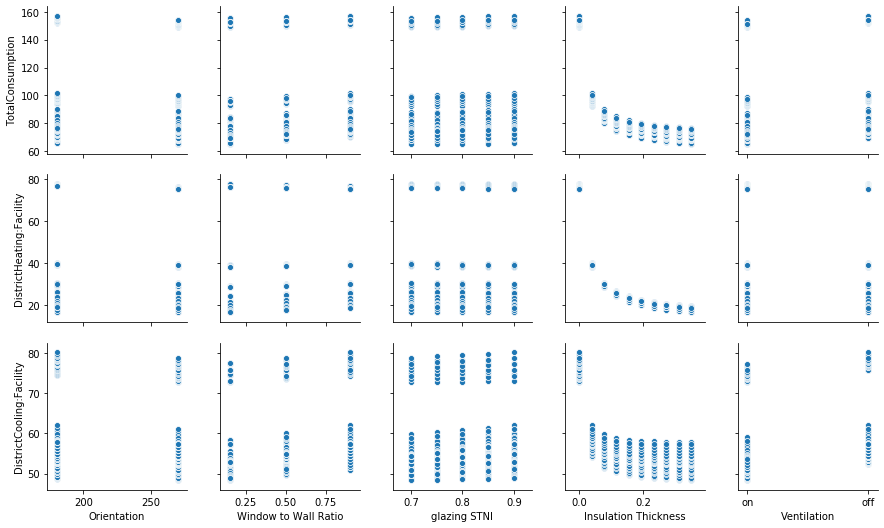

In [12]:
objectives = ['TotalConsumption', 'DistrictHeating:Facility', 'DistrictCooling:Facility']
_ = pairplot(results, x_vars=samples_for_plot.columns, y_vars=objectives, kind="scatter")

Text(0, 0.5, 'DistrictCooling:Facility')

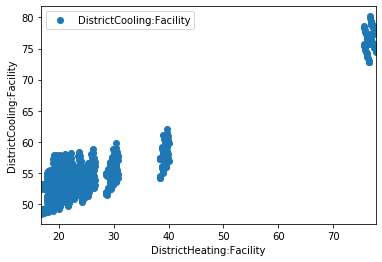

In [13]:
_ = results.plot(x=objectives[1], y=objectives[2], style='o')
plt.xlabel(objectives[1])
plt.ylabel(objectives[2])